Referemce: <br>
http://www.jakob-aungiers.com/articles/a/LSTM-Neural-Network-for-Time-Series-Prediction

Objective: <br>
1 window period with multiple epochs (using machine learning mastery lstm example)

In [90]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd


# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    #df.fillna(0, inplace=True)
    df.dropna(inplace=True)
    return df

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]



In [91]:
file=r"score_result_sinwave_original_1window.txt"

f = open( file, 'w' )
f.write('epoch|neuron|rmse \n' )
f.close()

In [92]:
series = read_csv('sinwave.csv', header=None,  squeeze=True,  names=['sin'])
raw_values = series.values
supervised = timeseries_to_supervised(raw_values, 1)
supervised_values = supervised.values
train, test = supervised_values[0:-100], supervised_values[-100:]
train_scaled=train
test_scaled=test

In [93]:
#nb_epoch_range=range(100,1100,100)
nb_epoch_range=[100]
neuron_range=[1]
for i1 in nb_epoch_range:
    for i2 in neuron_range:
        # repeat experiment
        repeats = 1
        error_scores = []
        for r in range(repeats):
            # fit the model
            lstm_model = fit_lstm(train_scaled, 1, i1, i2)
            # forecast the entire training dataset to build up state for forecasting
            train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
            lstm_model.predict(train_reshaped, batch_size=1)
            # walk-forward validation on the test data
            predictions = list()
            for i in range(len(test_scaled)):
                # make one-step forecast
                X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
                yhat = forecast_lstm(lstm_model, 1, X)
                ##used to check transform and inverted working correctly
                #yhat = y
                # invert scaling
                #yhat = invert_scale(scaler, yhat)
                # invert differencing
                #yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
                # store forecast
                predictions.append(yhat)
                expected = raw_values[len(train) + i]
                #print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
            # report performance
            rmse = sqrt(mean_squared_error(raw_values[-100:], predictions))
            #print('%d) Test RMSE: %.3f' % (r+1, rmse))
            error_scores.append([rmse])

            f = open( file, 'a' )
            f.write(str(i1)+'|'+str(i2)+'|'+str(rmse)+'\n' )
            f.close()

print("done")

done


In [94]:
import pandas as pd

#DataFrame.pivot_table(values=None, index=None, columns=None, aggfunc='mean',fill_value=None, margins=False, dropna=True)

df = pd.read_csv(file,  sep='|')
df.pivot_table(index='epoch',columns='neuron',aggfunc=('count','mean'))

rmse           
       count      mean
neuron     1         1
epoch                 
100        1  0.031577

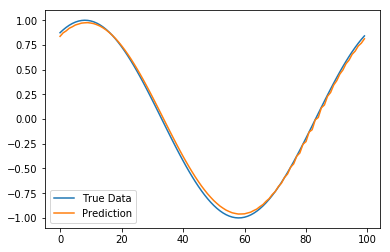

In [102]:
import matplotlib.pyplot as plt
true_data=raw_values[-100:]
predicted_data=predictions

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(true_data, label='True Data')
plt.plot(predicted_data, label='Prediction')
plt.legend()
plt.show()